# Train_state

### BA-1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from tqdm import trange
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## 1、DataCleaning

We start off by doing some data cleaning work.

In [2]:
training_data = pd.read_csv("data_state.csv") # Read in the training data
test_data = pd.read_csv("data_state_test.csv") # Read in the test data

In [3]:
training_data.head() # Check to see if we have correctly read in the data

,source,loan_id,Year_orig,Quarter_orig,delinquent30,frst_dte,orig_rt,orig_amt,oltv,ocltv,...,delinquent90,foreclosure,prepaid_cnt,seller,month,unemployment_rate,HPI_state,FRM30_rate,treasury_3mon_rate,weekly_income
0,FD,F100Q1023070,2000,1,0,2000-04-01,8.500,204000,79,79,...,0,0,1,COUNTRYWIDE,4,6.7,169.95,8.1525,5.66,674.0
1,FD,F100Q1039162,2000,1,0,2000-05-01,8.375,100000,34,34,...,0,0,1,"NORWESTMORTGAGE,INC",5,6.4,169.95,8.5150,5.79,674.0
2,FD,F100Q1050054,2000,1,0,2000-03-01,8.500,173000,95,95,...,0,0,1,"NORWESTMORTGAGE,INC",3,7.2,169.95,8.2400,5.69,674.0
3,FD,F100Q1002153,2000,1,0,2000-03-01,8.125,137000,80,80,...,0,0,1,"NORWESTMORTGAGE,INC",3,4.5,209.11,8.2400,5.69,555.0
4,FD,F100Q1005553,2000,1,0,2000-03-01,8.250,92000,95,95,...,0,0,1,Other sellers,3,4.5,209.11,8.2400,5.69,555.0


In [4]:
training_data.columns # Obtain the column information

Index(['source', 'loan_id', 'Year_orig', 'Quarter_orig', 'delinquent30',
       'frst_dte', 'orig_rt', 'orig_amt', 'oltv', 'ocltv', 'dti', 'cscore_b',
       'mi_pct', 'fthb_flg', 'num_bo', 'num_unit', 'state', 'cd_msa',
       'delinquent60', 'delinquent90', 'foreclosure', 'prepaid_cnt', 'seller',
       'month', 'unemployment_rate', 'HPI_state', 'FRM30_rate',
       'treasury_3mon_rate', 'weekly_income'],
      dtype='object')

In [5]:
selected_columns=['source','Quarter_orig','orig_rt' ,'orig_amt',  'oltv' , 'ocltv' , 'dti' , 'cscore_b' , 'mi_pct'  , 'num_bo' ,\
          'num_unit' ,'fthb_flg', 'FRM30_rate','treasury_3mon_rate','weekly_income','foreclosure', 'prepaid_cnt', 'unemployment_rate','delinquent30'] 

In [6]:
# Reorganize the columns of the data
training_data = training_data.reindex(columns=selected_columns)
test_data = test_data.reindex(columns=selected_columns)

In [7]:
training_data = training_data.fillna(method='ffill')
test_data = test_data.fillna(method='ffill')
# Fill in all the NaN value with the previous value

print('The number of NaN values in the training data and test data: %d and %d',sum(training_data.isnull().any()), sum(test_data.isnull().any()) )
# Check to see if there are any NaN values

The number of NaN values in the training data and test data: %d and %d 0 0


In [8]:
# Produce one hot encode
training_data = pd.get_dummies(training_data) 
test_data = pd.get_dummies(test_data)

In [9]:
# Convert the values into float datatype
training_data = pd.DataFrame(training_data, dtype=np.float32)
test_data = pd.DataFrame(test_data, dtype=np.float32)

From this point on we have finished data cleaning.

## 2、Utils

In [10]:
#Conserve the variables in 'training_data' except 'delinquent30' in 'features'
#'delinquent30' denotes 'label'
features = list(training_data.columns)
features.remove("delinquent30")
label = "delinquent30"

In [11]:
#Use X to denote features,and use Y to denote label
#Use different viariables to denote training data and test data
X_train = training_data[features].values
y_train = training_data[label].values
X_test = test_data[features].values
y_test = test_data[label].values

In [12]:
#Show the volumn of 4 data sets
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((433732, 19), (433732,), (65314, 19), (65314,))

In [13]:
#Normalize the features in both training data and test data
sc=StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [14]:
#use chi2(chi-square test) to score the features,and then select 10 features from high to low
selector = SelectKBest(chi2, k=10)
selector.fit(X_train, y_train)
X_train_select = selector.transform(X_train)
X_test_select = selector.transform(X_test)

#Normalize the features we selected 
X_train_sc_select = sc.fit_transform(X_train_select)
X_test_sc_select = sc.transform(X_test_select)

In [15]:
def compare(y_pred,y):
    """
    calculate the number of tp, fp, fn, tn of prediction
    """
    tp = np.sum((y_pred==True)&(y==1))
    fp = np.sum((y_pred==True)&(y==0))
    fn = np.sum((y_pred==False)&(y==1))
    tn = np.sum((y_pred==False)&(y==0))
    return tp,fp,fn,tn

The equation for calculating the net profit is derived as followed:

$$
\text{Net Profit}  = \sum \{ 0.5\% \times \text{not default loan balance}  - 20\% \times \text{default loan balance} \}
$$

We shall turn this into a function ```cal_net_profit```

In [16]:
def cal_net_profit(y_pred, y):
    """
    calculate the net profit under the prediction of y_pred
    """
    orig_amt = test_data['orig_amt'].values
    true_index = np.where(((y==0) & (y_pred==0)) == True)[0]
    false_index = np.where(((y==1) & (y_pred==0)) == True)[0]
    profit = np.sum(orig_amt[true_index] * 0.005)
    loss = np.sum(orig_amt[false_index] * 0.2)
    return profit - loss

In [17]:
ori_net_profit = cal_net_profit(np.array([0]*len(y_test)), y_test)

# 3、LogisticRegression

First we use the logistic regression to test out the result.

In [18]:
lr_clf = LogisticRegression(max_iter=200)

In consideration of the cost sensitivity of the model, we first use raw data to test out the model

### 3.1 Raw input

In [19]:
lr_clf.fit(X_train, y_train)
result = lr_clf.predict(X_test)
print(classification_report(y_test,result))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     61386
         1.0       0.00      0.00      0.00      3928

    accuracy                           0.94     65314
   macro avg       0.47      0.50      0.48     65314
weighted avg       0.88      0.94      0.91     65314



In [20]:
ps = [i/100 for i in range(100)]
errors = [] 
T1s = []
T2s = []
net_profits = []
for i in trange(len(ps)):
    p = ps[i]
    y_pred = np.where(lr_clf.predict_proba(X_test)[:,1] > p, 1, 0)
    tp,fp,fn,tn = compare(y_pred, y_test)
    net_profit = cal_net_profit(y_pred, y_test)
    error = 1-sum(y_pred==y_test)/len(y_test)
    T1e = fp/(tn+fp)
    T2e = fn/(fn+tp)
    errors.append(error)
    T1s.append(T1e)
    T2s.append(T2e)
    net_profits.append(net_profit-ori_net_profit)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.38it/s]


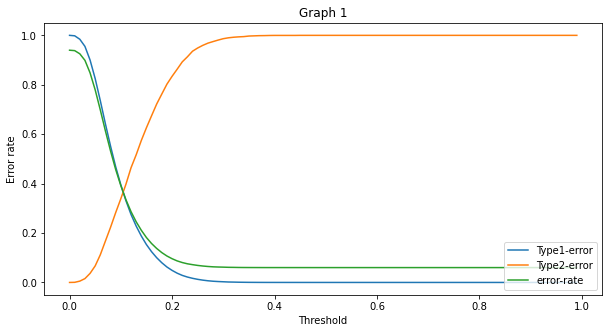

In [21]:
plt.figure(figsize=(10,5))
plt.plot(ps,T1s,label='Type1-error')
plt.plot(ps,T2s,label='Type2-error')
plt.plot(ps,errors,label='error-rate')
plt.xlabel("Threshold")
plt.ylabel("Error rate")
plt.title("Graph 1")
plt.legend(loc="lower right")

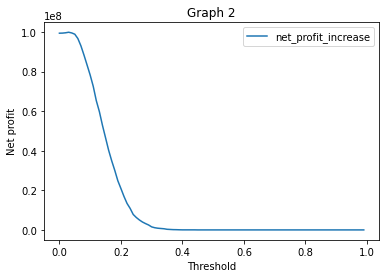

In [22]:
plt.plot(ps,net_profits, label='net_profit_increase')
plt.xlabel("Threshold")
plt.ylabel("Net profit")
plt.title("Graph 2")
plt.legend(loc="upper right")

In [23]:
print('The optimal threshold: ',ps[np.argmax(net_profits)])
print('The corresponding net profit increase: ',net_profits[3])

The optimal threshold:  0.03
The corresponding net profit increase:  99892710.0


Without standarization, the model have a tendency of being influenced by those features with great values, causing the classification process to be biased. Also, because of the imbalanced nature of our datat sets, the model doesn't a good job at classifying ```delinquent90=1``` datas. Also, according to the net profit equation, we can see that making a false decision on accepting a default loan balance will be very costy. To avoid that the model is trained to be more "conservative" in making decision, meaning that it chooses a low threshold, tends to rejecting loans. 

### 3.2 Standarized input 

In [24]:
lr_clf.fit(X_train_sc, y_train)
acc = lr_clf.score(X_test_sc,y_test)
print('Score: ',acc)

Score:  0.9430290596196834


In [25]:
result=lr_clf.predict(X_test_sc)
print(classification_report(y_test,result))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     61386
         1.0       1.00      0.05      0.10      3928

    accuracy                           0.94     65314
   macro avg       0.97      0.53      0.54     65314
weighted avg       0.95      0.94      0.92     65314



In [26]:
# Plot the graph of error-rate vs. threshold

ps = [i/100 for i in range(100)]
errors = [] 
T1s = []
T2s = []
net_profits = []
for i in trange(len(ps)):
    p = ps[i]
    y_pred = np.where(lr_clf.predict_proba(X_test_sc)[:,1] > p, 1, 0)
    tp,fp,fn,tn = compare(y_pred, y_test)
    net_profit = cal_net_profit(y_pred, y_test)
    error = 1-sum(y_pred==y_test)/len(y_test)
    T1e = fp/(tn+fp)
    T2e = fn/(fn+tp)
    errors.append(error)
    T1s.append(T1e)
    T2s.append(T2e)
    net_profits.append(net_profit-ori_net_profit)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.80it/s]


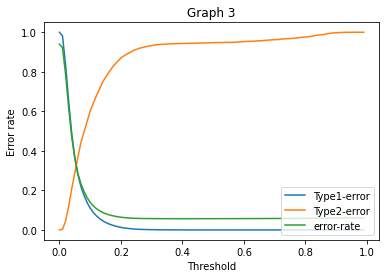

In [27]:
plt.plot(ps,T1s,label='Type1-error')
plt.plot(ps,T2s,label='Type2-error')
plt.plot(ps,errors,label='error-rate')
plt.xlabel("Threshold")
plt.ylabel('Error rate')
plt.title('Graph 3')
plt.legend(loc="lower right")

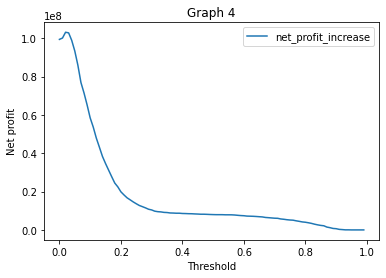

In [28]:
plt.plot(ps,net_profits, label='net_profit_increase')
plt.xlabel("Threshold")
plt.ylabel("Net profit")
plt.title("Graph 4")
plt.legend(loc="upper right")

In [29]:
index=int(ps[np.argmax(net_profits)]*100)
print('The optimal threshold: ',ps[np.argmax(net_profits)])
print('The corresponding net profit increase: ',net_profits[index])
print('The net profit: ',net_profits[index]+ori_net_profit)

The optimal threshold:  0.02
The corresponding net profit increase:  103143290.0
The net profit:  3731784.0


The model can certainly do better on classifying the default loan, but for the same reason above the threshold is still low. Anyways, now the model is able to yield a net profit greater compared with the model using raw input training data

### 3.3 Standarized input after feature selection 

In [30]:
lr_clf.fit(X_train_sc_select, y_train)
acc = lr_clf.score(X_test_sc_select,y_test)
print('Score: ',acc)

Score:  0.9432434087638178


In [31]:
result=lr_clf.predict(X_test_sc_select)
print(classification_report(y_test,result))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     61386
         1.0       1.00      0.06      0.11      3928

    accuracy                           0.94     65314
   macro avg       0.97      0.53      0.54     65314
weighted avg       0.95      0.94      0.92     65314



In [32]:
ps = [i/100 for i in range(100)]
errors = [] 
T1s = []
T2s = []
net_profits = []
for i in trange(len(ps)):
    p = ps[i]
    y_pred = np.where(lr_clf.predict_proba(X_test_sc_select)[:,1] > p, 1, 0)
    tp,fp,fn,tn = compare(y_pred, y_test)
    net_profit = cal_net_profit(y_pred, y_test)
    error = 1-sum(y_pred==y_test)/len(y_test)
    T1e = fp/(tn+fp)
    T2e = fn/(fn+tp)
    errors.append(error)
    T1s.append(T1e)
    T2s.append(T2e)
    net_profits.append(net_profit-ori_net_profit)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.96it/s]


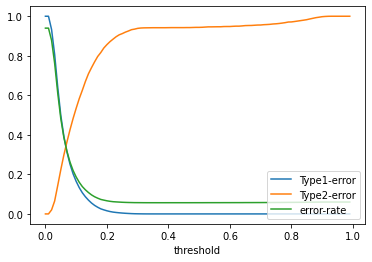

In [33]:
plt.plot(ps,T1s,label='Type1-error')
plt.plot(ps,T2s,label='Type2-error')
plt.plot(ps,errors,label='error-rate')
plt.xlabel("threshold")
plt.legend(loc="lower right")

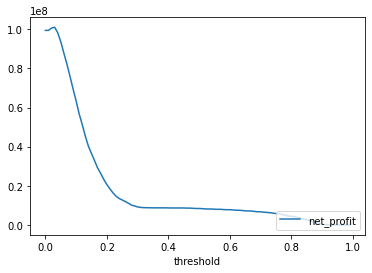

In [34]:
plt.plot(ps,net_profits,label='net_profit')
plt.xlabel("threshold")
plt.legend(loc="lower right")

In [35]:
index=int(ps[np.argmax(net_profits)]*100)
print('The optimal threshold: ',ps[np.argmax(net_profits)])
print('The corresponding net profit increase: ',net_profits[index])
print('The net profit: ',net_profits[index]+ori_net_profit)

The optimal threshold:  0.03
The corresponding net profit increase:  101016184.0
The net profit:  1604680.0


## 4、KNN

In [36]:
#use knn algorithm which select 5 nearest points
knn_clf = KNeighborsClassifier(n_neighbors = 5)
knn_clf.fit(X_train_sc, y_train)

#score the fitting effect,we can see that the outcome is close to 1,which means the fitting effect is great
acc = knn_clf.score(X_test_sc,y_test)
acc

0.9418348286737912

In [37]:
result=knn_clf.predict(X_test_sc)
print(classification_report(y_test,result))
#from the outcome,we can see that f1-score of no delinquency(0)is close to 1,which means the prediction of no delinquency is accurate.
#wherea,f1-score of delinquency(1)is far from 1,which means the prediction of delinquency is suspicious.
#for the reason that weighted avg is close to 1,generally speaking,we may speculate taht knn algorithm performs well in this data set.But we still can't ignore the inaccurate predictyion of delinquency(1),because it bring great loss to the bank.

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     61386
         1.0       0.67      0.06      0.12      3928

    accuracy                           0.94     65314
   macro avg       0.81      0.53      0.54     65314
weighted avg       0.93      0.94      0.92     65314



In [38]:
"""TODO"""
#calculate the type1 error,type2 error,error rate and net profit.
ps = [i/20 for i in range(20)]
errors = []
T1s = []
T2s = []
net_profits = []
for i in trange(len(ps)):
    p = ps[i]
    y_pred = np.where(knn_clf.predict_proba(X_test)[:,1] > p, 1, 0)
    tp,fp,fn,tn = compare(y_pred, y_test)
    net_profit = cal_net_profit(y_pred, y_test)
    error = 1-sum(y_pred==y_test)/len(y_test)
    T1e = fp/(tn+fp)
    T2e = fn/(fn+tp)
    errors.append(error)
    T1s.append(T1e)
    T2s.append(T2e)
    net_profits.append(net_profit-ori_net_profit)

  0%|                                                                                           | 0/20 [07:37<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
plt.plot(ps,T1s,label='Type1-error')
plt.plot(ps,T2s,label='Type2-error')
plt.plot(ps,errors,label='error-rate')
plt.xlabel("threshold")
plt.legend(loc="lower right")

ValueError: x and y must have same first dimension, but have shapes (20,) and (0,)

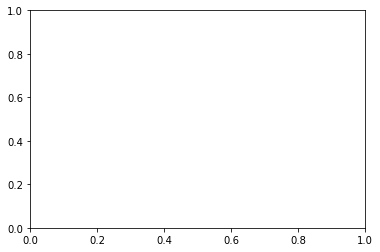

In [41]:
plt.plot(ps,net_profits,label='net_profit_increase')
plt.xlabel("threshold")
plt.legend(loc="lower right")

## 5、DecisionTree

In [42]:
tree_clf = DecisionTreeClassifier(class_weight={0:1.0, 1:10})
tree_clf.fit(X_train_sc_select, y_train)

DecisionTreeClassifier(class_weight={0: 1.0, 1: 10})

In [43]:
tree_clf.score(X_test_sc_select,y_test)

0.8999601923018036

In [44]:
result=tree_clf.predict(X_test_sc_select)
print(classification_report(y_test,result))

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95     61386
         1.0       0.15      0.14      0.15      3928

    accuracy                           0.90     65314
   macro avg       0.55      0.55      0.55     65314
weighted avg       0.90      0.90      0.90     65314



In [46]:
weights = [i for i in range(10,200,10)]
errors = [] 
T1s = []
T2s = []
net_profits = []
for i in trange(len(weights)):
    weight = {0:1.0, 1:weights[i]}
    tree_clf = DecisionTreeClassifier(class_weight=weight)
    tree_clf.fit(X_train_sc_select, y_train)
    y_pred = tree_clf.predict(X_test_sc_select)
    tp,fp,fn,tn = compare(y_pred, y_test)
    net_profit = cal_net_profit(y_pred, y_test)
    error = 1-sum(y_pred==y_test)/len(y_test)
    T1e = fp/(tn+fp)
    T2e = fn/(fn+tp)
    errors.append(error)
    T1s.append(T1e)
    T2s.append(T2e)
    net_profits.append(net_profit-ori_net_profit)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [02:00<00:00,  6.33s/it]


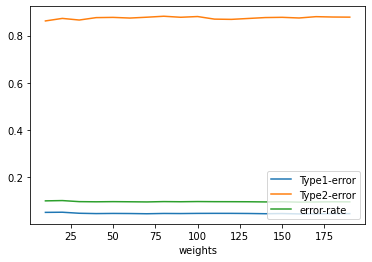

In [47]:
plt.plot(weights,T1s,label='Type1-error')
plt.plot(weights,T2s,label='Type2-error')
plt.plot(weights,errors,label='error-rate')
plt.xlabel("weights")
plt.legend(loc="lower right")

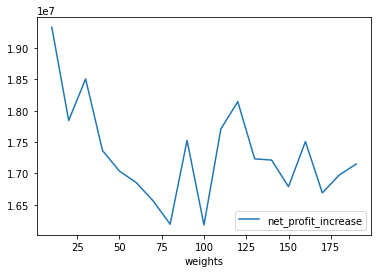

In [48]:
plt.plot(weights,net_profits,label='net_profit_increase')
plt.xlabel("weights")
plt.legend(loc="lower right")

## 6、RandomForest

In [49]:
#score the fitting effect,we can see that the outcome is close to 1,which means the fitting effect is great
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_sc_select, y_train)
rf_clf.score(X_test_sc_select,y_test)

0.9429065743944637

In [50]:
#prediction with automatic weight
result=rf_clf.predict(X_test_sc_select)
print(classification_report(y_test,result))
#from the outcome,we can see that f1-score of no delinquency(0)is close to 1,which means the prediction of no delinquency is accurate.
#wherea,f1-score of delinquency(1)is far from 1,which means the prediction of delinquency is suspicious.
#for the reason that weighted avg is close to 1,generally speaking,we may speculate that randomforest algorithm with automatic weight performs well in this data set.But we still can't ignore the inaccurate predictyion of delinquency(1),because it bring great loss to the bank.

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     61386
         1.0       0.85      0.06      0.11      3928

    accuracy                           0.94     65314
   macro avg       0.90      0.53      0.54     65314
weighted avg       0.94      0.94      0.92     65314



In [51]:
#improve the weight of delinquency(1)
rf_clf = RandomForestClassifier(class_weight={0: 1.0, 1.0: 20.0})
rf_clf.fit(X_train_sc_select, y_train)

RandomForestClassifier(class_weight={0: 1.0, 1.0: 20.0})

In [52]:
#prediction with set weight
result=rf_clf.predict(X_test_sc_select)
print(classification_report(y_test,result))
#from the outcome,we can see that f1-score of no delinquency(0)is close to 1,which means the prediction of no delinquency is accurate.
#we find that the precision of delinquency increases a lot from 0.88 to 0.97,but with recall value only 0.06,f1-score of delinquency(1)is still far from 1,which means the prediction of delinquency is suspicious.
#for the reason that weighted avg is close to 1,generally speaking,we may speculate that randomforest algorithm with set weight performs well in this data set.But we still can't ignore the inaccurate predictyion of delinquency(1),because it bring great loss to the bank.

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     61386
         1.0       0.96      0.06      0.11      3928

    accuracy                           0.94     65314
   macro avg       0.95      0.53      0.54     65314
weighted avg       0.94      0.94      0.92     65314



In [53]:
#calculate the type1 error,type2 error,error rate and net profit for each weight. 
weights = [i for i in range(10,200,10)]
errors = [] 
T1s = []
T2s = []
net_profits = []
for i in trange(len(weights)):
    weight = {0:1.0, 1:weights[i]}
    rf_clf = RandomForestClassifier(class_weight=weight)
    rf_clf.fit(X_train_sc_select, y_train)
    y_pred = rf_clf.predict(X_test_sc_select)
    tp,fp,fn,tn = compare(y_pred, y_test)
    net_profit = cal_net_profit(y_pred, y_test)
    error = 1-sum(y_pred==y_test)/len(y_test)
    T1e = fp/(tn+fp)
    T2e = fn/(fn+tp)
    errors.append(error)
    T1s.append(T1e)
    T2s.append(T2e)
    net_profits.append(net_profit-ori_net_profit)

 32%|█████████████████████████▉                                                        | 6/19 [11:59<25:58, 119.91s/it]


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (19,) and (6,)

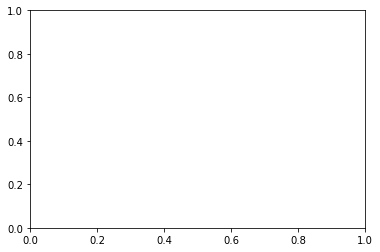

In [55]:
plt.plot(weights,T1s,label='Type1-error')
plt.plot(weights,T2s,label='Type2-error')
plt.plot(weights,errors,label='error-rate')
plt.xlabel("weights")
plt.legend(loc="lower right")

In [ ]:
plt.plot(weights,net_profits,label='net_profit_increase')
plt.xlabel("weights")
plt.legend(loc="lower right")

## 7、NeuralNetwork

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.utils import data
import torch.nn.functional as F

n_features = X_train_sc.shape[1]
training_features = torch.from_numpy(X_train_sc)
training_labels = torch.from_numpy(y_train)
training_features = training_features.float()

testing_features = torch.from_numpy(X_test_sc)
testing_features = testing_features.float()

#read the data set
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """Construct a PyTorch data iterator"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((training_features, training_labels), batch_size)

#create the model(We just use the logistic regression to control the threshold)
net = nn.Sequential(
    nn.Linear(n_features,128), torch.nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(128,64), torch.nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(64,16), torch.nn.ReLU(),
    nn.Linear(16,4), torch.nn.ReLU(),
    nn.Linear(4,2),  # 第二隐层与输出层层结点数设置，全连接结构
    nn.Softmax(dim=1) # 由于有两个概率输出，因此对其使用Softmax进行概率归一化
)


#Loss and optimizer
optimizer = torch.optim.SGD(net.parameters(),lr=0.01,momentum = 0.1) # 优化器使用随机梯度下降，传入网络参数和学习率
loss_func = torch.nn.CrossEntropyLoss() # 损失函数使用交叉熵损失函数

#training the model
num_epoch = 2000 # 最大迭代更新次数
for epoch in range(num_epoch):
    y_p = net(training_features)  # 喂数据并前向传播

    loss = loss_func(y_p,training_labels.long()) # 计算损失

    optimizer.zero_grad()  # 清除梯度
    loss.backward()  # 计算梯度，误差回传
    optimizer.step()  # 根据计算的梯度，更新网络中的参数

    if epoch % 200 == 0:
        print('epoch: {}, loss: {}'.format(epoch, loss.data.item()))

In [ ]:
y_pred_proba = net(testing_features)
y_pred_proba = y_pred_proba.detach().numpy()
y_pred_proba 

In [ ]:
y_pred = np.where(y_pred_proba[:,1] > 0.02, 1, 0)
print(classification_report(y_test,y_pred))
net_profit = cal_net_profit(y_pred, y_test)
print("The net profit is: "net_profit)

### 3.4 customize class_weight parameter

In [ ]:
penalty = {
    0 : 1,
    1 : 30
}
lr = LogisticRegression(class_weight = penalty)
lr.fit(X_train_sc, y_train, sample_weight = sample_weight)

In [ ]:
y_pred=lr.predict(X_test_sc)
print(classification_report(y_test,y_pred))

In [ ]:
net_profit = cal_net_profit(y_pred, y_test)
print(net_profit)

In [ ]:
lr.predict_proba(X_test_sc)

### 3.5 Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
 
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train_sc, y_train)
X_resampled.shape,y_resampled.shape

# Oversample
lr_clf.fit(X_resampled, y_resampled)
acc = lr_clf.score(X_test_sc,y_test)
print('Score: ',acc)

result=lr_clf.predict(X_test_sc)
print(classification_report(y_test,result))